# PSSM generation

Generate PSSM files to extract evolutionary features. Using Mmseqs the process can be really fast.  

However, I have found a problem (I don't know if it is an bug or not) in the program and created an issue to the Mmseqs team. So at the moment it is down.

In [2]:
from BioML.utilities.utils import MmseqsClustering

In [7]:
fasta_file = "../data/whole_sequence.fasta"

In [3]:
pssm_file = MmseqsClustering.easy_generate_pssm(input_file=fasta_file, database_input=fasta_file,
output_database="../data/whole_sequence", generate_searchdb=True, pssm_filename="esterase.pssm")

start running createdb
It took 0.008338212966918945 second to run
start running search
It took 2.8009424209594727 second to run
start running generate_profile
It took 0.08434319496154785 second to run
start running convert profile to pssm
It took 0.04231381416320801 second to run


In [4]:
MmseqsClustering.split_pssm(pssm_file)

# Extract Features

There are several features to extract:
   1. Physicochemical features from iFeatures https://github.com/Superzchen/iFeature
   2. It might be great to incorporate other features the Lab is using like the Onehot encoding and the AA index
   3. Evolutionary features using PSSM and Possum https://possum.erc.monash.edu/
   4. Features or embeddings from Large language models 

Before substrate extraction you might want to clean the fast file of non canonical residues like X, U, B etc and to remove those shorter than 100 aamino acids for example

In [1]:
from BioML.features.extraction import PossumFeatures, IfeatureFeatures, read_features
from BioML.utilities.utils import clean_fasta

In [5]:
clean_fasta("/home/ruite/Projects/enzyminer/POSSUM_Toolkit", fasta_file, "cleaned.fasta", 100)
fasta_file = "cleaned.fasta"

Success!
The sequences shorter than 100 will be removed!
Success!


In [18]:
ifeatures = IfeatureFeatures("/home/ruite/Projects/enzyminer/iFeature")
ifeatures.extract(fasta_file)

iFeature features to be extracted: {'long': ['NMBroto', 'Moran', 'Geary'], 'short': ['CKSAAGP', 'PAAC', 'CTDD', 'GDPC', 'APAAC', 'GAAC', 'GTPC', 'SOCNumber', 'CTDT', 'KSCTriad', 'CTDC', 'CTriad', 'QSOrder']}


start running Ifeature programs
It took 16.37057065963745 second to run


In [4]:
possum = PossumFeatures(pssm_dir="pssm", program="/home/ruite/Projects/enzyminer/POSSUM_Toolkit")
possum.extract(fasta_file)

Possum features to be extracted: {'long': ['tri_gram_pssm', 'pssm_cc'], 'short': ['edp', 'd_fpssm', 'rpssm', 'pssm_ac', 'pssm_composition', 'pse_pssm:2', 's_fpssm', 'pse_pssm:3', 'tpc', 'aac_pssm', 'smoothed_pssm:7', 'k_separated_bigrams_pssm', 'eedp', 'ab_pssm', 'smoothed_pssm:5', 'smoothed_pssm:9', 'dpc_pssm', 'rpm_pssm', 'dp_pssm', 'pse_pssm:1']}
start running Possum programs
It took 494.46776008605957 second to run


##  LLM embeddings

If you want you can easily generate large language model embeddings from models supported by Hugging Face's API

In [2]:
from BioML.deep import embeddings

In [4]:
embeddings.generate_embeddings(fasta_file, model_name="facebook/esm2_t6_8M_UR50D", option="mean", save_path="embeddings.csv", mode="write")

## Feature selection

If we combine features from multiple places the dimensions would be too high to handle, so normally ti would be wise to use some feature selection techniques: 
    1. Supervised: using Tree methods, Recursive feature elmination
    2. Filter methods: Pearson correlation etc
    3. TODO: Unsupervised methods like: PCA, ICA (independent component analysis)

In [2]:
import pandas as pd
from BioML.features import methods, selection

In [3]:
ifeat = read_features("ifeature", ifeature_out="ifeature_features", file_splits=1)
possum_feat = read_features("possum", possum_out="possum_features", file_splits=1, index=ifeat.index)
emb = pd.read_csv("embeddings.csv", index_col=0)

In [4]:
emb.columns.shape, ifeat.columns.shape, possum_feat.columns.shape

((320,), (2274,), (18730,))

The DataReader function takes:
* label in different formats: string, ndarray, a list of pd.Series.
* It also takes features in different formats: a list, ndarray, dataframe, list of dataframes or a list of the different accepted formats and concatenates them

It will automatically remove features with 0 variance (meaning every value is the same), you can control the threshold

In [5]:
features = selection.DataReader("../data/esterase_labels.csv", [ifeat, emb, possum_feat], variance_thres=0.005)
features

Data with:
    num. samples: 147
    num. columns: 7096
    variance threshold: 0.005
    sheet: None

Depending on the problem you might use one of the feature selection classes: The name is quite self-explanatory.

The get_range_features retuns a list of feature dimensions to extract and it will generate an excel file with those features, the number of sheets will be len(feature_range) * number of selection algorithms

It will also output an plot of the feature importance with the shap package https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/

In [8]:
problem="classification"
feature_range = selection.get_range_features(features.features, num_features_min =None, num_features_max=65, step_range=None)
feature_range

[13, 26, 39, 52, 65]

27-05-2024 09:56:38 INFO Reading the features
27-05-2024 09:56:38 INFO Starting feature selection and using the following parameters
27-05-2024 09:56:38 INFO seed: 10
27-05-2024 09:56:38 INFO filtering the features


classification filter: mutual_info
classification filter: Fscore
classification filter: chi2
classification filter: FechnerCorr
classification filter: KendallCorr
generating a feature set of 50 dimensions


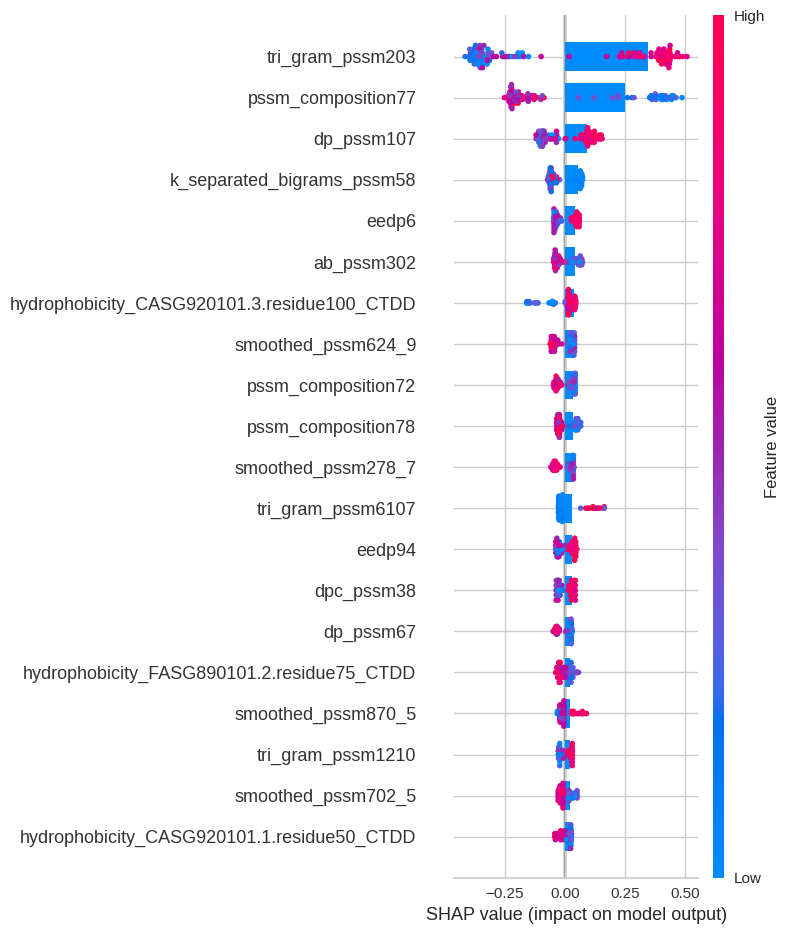

In [9]:

filters = selection.FeatureSelection("filtered_features.xlsx", num_thread=2, seed=10)
# select features
if problem == "classification":
    select = selection.FeatureClassification(filters.seed, scaler="robust", test_size=0.2)
elif problem == "regression":
    select = selection.FeatureRegression(filters.seed, scaler="robust", test_size=0.2)
feature_range = [50]
select.construct_features(features.features, features.label, filters, feature_range)

### Outlier detection

You can also eliminate outliers in your dataset that could decrease model performance.
Generally, if you have a lot of data outliers won't matter much
You give it the filtered features:
1. It also accepts different formats: excel files
2. Pandas dataframe
3. Series, ndarray
4. csv file

It leverages 10 different outlier detection algorithms and gives you a voting. If you give it an excel file where there are features on each sheet. It will use all of them.

In [11]:
from BioML.utilities.outlier import OutlierDetection

In [12]:
detection = OutlierDetection("filtered_features.xlsx", num_thread=4)
outliers = detection.run()

using FechnerCorr_50 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.2s remaining:    1.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.2s finished


using rfe_50 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using KendallCorr_50 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using Fscore_50 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using random_50 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using mutual_info_50 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using chi2_50 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using xgbtree_50 for outlier calculations
saving the outlier file


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


In [13]:
outliers.head(20)

EH75(16)     64
EH46(23)     61
EH51(22)     43
EH130(2)     37
EH97(11)     32
EH137(2)     28
EH142(1)     28
EH84(13)     22
EH143(1)     19
EH102(10)    16
EH144(1)     14
EH106(9)     13
EH125(4)     12
EH82(14)      8
EH35(29)      8
EH57(21)      8
EH89(13)      7
EH70(18)      7
EH80(14)      7
EH44(25)      7
dtype: int64

## Custom splitting based on 30% sequence identity

It is recommended to split based on sequence identity so that the training, test or validation sets doesn't have sequence with more than 30% sequence identity.
You can use mmseqs to generate such clusters

In [6]:
from BioML.utilities.utils import MmseqsClustering
from BioML.utilities.split_methods import ClusterSpliter
from BioML.models.base import DataParser
import pandas as pd
from sklearn.model_selection import train_test_split
from pathlib import Path

Generate different clusters of sequences based on an identity threshold of 30%.
It creates a cluster.tsv file. This tsv file has the first column the clusters names (which should be the same one as the features indices) and in the second column the idex of the sequence that resides within that cluster.  

For example: This means EH2(71) is a cluster with 3 sequences that share more than 30% sequence identity.

* EH2(71)	EH2(71)
* EH2(71)	EH4(67)
* EH2(71)	EH14(48)

This technique is actually very flexible, you can generate manually a cluster file if you want to customize the way you want to split your data into training and testing splits

In [8]:
cluster = MmseqsClustering.easy_cluster(fasta_file, cluster_at_sequence_identity=0.3)

start running cluster
It took 0.0032303333282470703 second to run
start running create tsv
It took 0.023415327072143555 second to run


Now split based on this sequence identity cluster, the clusters can use strings or numbers as long as it is the same as the index of feautures dataframe.  
But if they are different, meaning the cluster tsv has cluster names different to the index of the dataframe, there is an additional index argument in the split and train_test_split function that accepts a list with the same shape as the dataframe where the elements should have the same names as in the cluster file

The Dataparser returns a dataframe with the labels already in the same dataframe, which is why we don't need the y_train and the y_test.
This is how Pycaret likes it (the library used by BioML to train machine learning models) 

Here I'm only using one of the sheets for this example, but we don't know which of the sheets would perform better so we might need to iterate through the sheets, train the models and collect the performance to know which sheet perfoms better

In [7]:
split = ClusterSpliter("cluster.tsv", num_splits=5, random_state=100, stratified=True)
data = DataParser("filtered_features.xlsx", "../data/esterase_labels.csv", sheets="chi2_50")
X_train, X_test, _, _ = split.train_test_split(data.features, data.features[data.label])

In [10]:
X_train

,hydrophobicity_ARGP820101.3.residue25_CTDD,hydrophobicity_PONP930101.2.residue25_CTDD,hydrophobicity_CASG920101.2.residue75_CTDD,normwaalsvolume.3.residue50_CTDD,polarizability.2.residue75_CTDD,polarizability.3.residue50_CTDD,charge.1.residue25_CTDD,charge.3.residue75_CTDD,secondarystruct.3.residue50_CTDD,solventaccess.1.residue75_CTDD,...,k_separated_bigrams_pssm57,k_separated_bigrams_pssm69,k_separated_bigrams_pssm71,k_separated_bigrams_pssm87,k_separated_bigrams_pssm89,k_separated_bigrams_pssm103,k_separated_bigrams_pssm106,k_separated_bigrams_pssm108,k_separated_bigrams_pssm111,target
EH111(8),28.063241,28.853755,72.727273,44.664032,75.494071,44.664032,22.134387,75.889328,45.849802,71.146245,...,0.1139,0.5774,0.7877,0.1619,0.1598,0.5521,0.4948,0.1810,0.4380,0
EH15(42),27.303754,30.034130,73.037543,43.344710,78.156997,43.344710,23.549488,81.911263,49.829352,77.815700,...,0.0637,0.5453,0.3697,0.2851,0.1417,0.3553,0.3478,0.2033,0.1990,1
EH117(6),24.197002,26.766595,73.875803,43.683084,79.871520,43.683084,22.269807,79.657388,47.109208,74.089936,...,0.3316,1.4192,1.3787,0.2621,0.2442,0.9034,0.9543,0.4614,0.7471,0
EH11(53),20.322581,29.677419,71.290323,60.322581,75.483871,60.322581,20.967742,72.903226,48.387097,78.064516,...,0.0728,0.6276,0.3115,0.1717,0.1582,0.4158,0.3956,0.1666,0.1521,1
EH135(2),20.996441,27.402135,72.953737,49.110320,74.377224,49.110320,20.284698,74.377224,43.060498,76.868327,...,0.3491,0.6415,0.7879,0.6351,0.1436,0.5461,0.4663,0.3078,0.4083,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EH86(13),29.702970,27.722772,78.217822,46.864686,73.267327,46.864686,7.590759,75.577558,46.534653,75.247525,...,0.0844,0.5655,0.3234,0.1575,0.1448,0.3873,0.3416,0.1721,0.1593,0
EH102(10),23.041475,20.276498,78.341014,49.308756,77.419355,49.308756,24.423963,66.820276,38.709677,77.419355,...,0.1108,0.7417,0.7898,0.2392,0.1605,0.4444,0.4739,0.1667,0.4562,0
EH66(19),20.069204,22.491349,74.740484,49.826990,72.318339,49.826990,13.840830,80.968858,46.366782,75.778547,...,0.1602,0.7147,0.7956,0.2435,0.1459,0.6328,0.6648,0.2627,0.3109,0
EH23(34),30.747126,26.149425,72.701149,45.689655,70.402299,45.689655,22.988506,79.022989,55.747126,70.402299,...,0.0797,0.7124,0.4266,0.2911,0.1478,0.4784,0.4949,0.2683,0.3029,1


## Classification

In [1]:
from BioML.models.classification import Classifier
from BioML.models.base import PycaretInterface, Trainer
from collections import defaultdict
from functools import partial
import pandas as pd
import numpy as np

In [2]:
plot = ("learning", "confusion_matrix", "class_report")

There are 3 classes important for training machine learning models in BioML. The pycaretInterface which provides a thin layer between pycaret and BioML.
Classifer or Regressor claases which has the training arguments used by the Trainer to perform classification or regression task.
This modularity is similar to other machine learning framewoeks like pytorch-lightning and Hugging Face (of course theirs are more impressive)

I recommend learning more about pycaret since it does many things: https://pycaret.readthedocs.io/en/latest/

Currently there are 19 supported models, but you can supply your custom models as well as long as it is compatible with the scikit learn API. A fit and a predict or predict_proba methods 

In [4]:
experiment = PycaretInterface("classification", 250, budget_time=20, best_model=3, 
                                  output_path="classification_training", optimize="MCC")
classifier = Classifier(optimize="MCC", drop=(), selected=(), add=())
training = Trainer(experiment, classifier, num_splits=5, test_size=0.2,  num_iter=50)

26-05-2024 20:53:21 INFO ------------------------------------------------------------------------------
26-05-2024 20:53:21 INFO PycaretInterface parameters
26-05-2024 20:53:21 INFO Seed: 250
26-05-2024 20:53:21 INFO Budget time: 20
26-05-2024 20:53:21 INFO The number of models to select: 3
26-05-2024 20:53:21 INFO Output path: classification_training
26-05-2024 20:53:21 INFO ----------------Trainer inputs-------------------------
26-05-2024 20:53:21 INFO Number of kfolds: 5
26-05-2024 20:53:21 INFO Number of retuning iterations: 50
26-05-2024 20:53:21 INFO Test size: 0.2


The results is a nested dictionary with the results for the different models, ensemble of models and stacking of the models.

The models is another nested dictionary with the trained models


In [8]:
results, models = training.generate_training_results(X_train, data.label, tune=True, test_data=X_test, fold_strategy=split)

26-05-2024 20:53:37 INFO --------------------------------------------------------
26-05-2024 20:53:37 INFO Training classification models
26-05-2024 20:53:37 INFO The models used ['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'gpc', 'mlp', 'ridge', 'rf', 'qda', 'ada', 'gbc', 'lda', 'et', 'xgboost', 'lightgbm', 'catboost', 'dummy']
26-05-2024 20:53:37 INFO The number of models used 19
26-05-2024 20:53:37 INFO Time budget is 20 minutes
26-05-2024 20:53:40 INFO Model ada trained in 0.045 minutes
26-05-2024 20:53:42 INFO Model svm trained in 0.03 minutes
26-05-2024 20:53:43 INFO Model ridge trained in 0.014 minutes
26-05-2024 20:53:44 INFO Model xgboost trained in 0.017 minutes
26-05-2024 20:53:44 INFO Model nb trained in 0.015 minutes
26-05-2024 20:55:26 INFO Model lightgbm trained in 1.69 minutes
26-05-2024 20:55:28 INFO Model gpc trained in 0.031 minutes
26-05-2024 20:55:29 INFO Model knn trained in 0.017 minutes
26-05-2024 20:55:30 INFO Model rbfsvm trained in 0.015 minutes
26-05-2024 20:5

In [17]:
results["not_tuned"]["holdout"][0].head()

Accuracy     AUC  Recall   Prec.      F1   Kappa  \
       Split    Fold                                                     
rbfsvm CV-Train Mean    0.8977  0.9710  0.8223  0.9607  0.8858  0.7942   
                Std     0.0115  0.0066  0.0272  0.0112  0.0146  0.0234   
       CV-Val   Mean    0.7565  0.7831  0.6638  0.8219  0.7267  0.5076   
                Std     0.0626  0.0433  0.0747  0.1189  0.0589  0.1245   
ridge  CV-Train Mean    0.9365  0.9769  0.9110  0.9559  0.9327  0.8727   

                         MCC  Average Precision Score  
       Split    Fold                                   
rbfsvm CV-Train Mean  0.8024                   0.9742  
                Std   0.0211                   0.0060  
       CV-Val   Mean  0.5245                   0.8311  
                Std   0.1330                   0.0532  
ridge  CV-Train Mean  0.8740                   0.0000

Then if we want we can generate the predictions for the test or holdout set by providing with the trained models and finally we save noth the training and the test set results

In [9]:
test_set_predictions = training.generate_holdout_prediction(models)

In [12]:
training_output = "classification_results"
l = []
for tune_status, result_dict in results.items():
    for key, value in result_dict.items():
        write_results(f"{training_output}/{tune_status}", *value, sheet_name=key)
    write_results(f"{training_output}/{tune_status}", test_set_predictions[tune_status] , sheet_name=f"test_results")

This is an example of using one feature set, but if you had various features sets that you want to test you could use iterate_excel from the utilities and the iterate_multiple_features method from Trainer.

The method accepts an iterator of (feature dataframe, label column name, name): 
    1. name is used to identify the features later in the results
    2. feature dataframe should contain a column with teh labels
    3. label column name within the feature dataframe

Then it calls the run_training method from the Trainer iteratively and gathers performance metrics for different sheets.
run_training only runs the models without tuning, stacking or esembling.
Finally it write the results for each sheet

Once you have picked the best performing sheet you could run again the previous steps then perform tuning, stacking and ensembling

Iterate excel reads all the sheets from an excel and yields (feature dataframe, label column name, sheet)

In [3]:
from BioML.utilities.utils import write_results, iterate_excel
from BioML.models.base import DataParser

In [4]:
experiment = PycaretInterface("classification", 250, budget_time=20, best_model=3, 
                                  output_path="classification_results", optimize="MCC")
classifier = Classifier(optimize="MCC", drop=(), selected=(), add=())
training = Trainer(experiment, classifier, num_splits=5, test_size=0.2,  num_iter=50)

26-05-2024 21:40:26 INFO ------------------------------------------------------------------------------
26-05-2024 21:40:26 INFO PycaretInterface parameters
26-05-2024 21:40:26 INFO Seed: 250
26-05-2024 21:40:26 INFO Budget time: 20
26-05-2024 21:40:26 INFO The number of models to select: 3
26-05-2024 21:40:26 INFO Output path: classification_results
26-05-2024 21:40:26 INFO ----------------Trainer inputs-------------------------
26-05-2024 21:40:26 INFO Number of kfolds: 5
26-05-2024 21:40:26 INFO Number of retuning iterations: 50
26-05-2024 21:40:26 INFO Test size: 0.2


In [5]:
generator = iterate_excel("filtered_features.xlsx", parser=DataParser, label="../data/esterase_labels.csv", outliers=())
training.iterate_multiple_features(generator, training_output="classification_results")

26-05-2024 21:40:29 INFO --------------------------------------------------------
26-05-2024 21:40:29 INFO Training classification models
26-05-2024 21:40:29 INFO The models used ['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'gpc', 'mlp', 'ridge', 'rf', 'qda', 'ada', 'gbc', 'lda', 'et', 'xgboost', 'lightgbm', 'catboost', 'dummy']
26-05-2024 21:40:29 INFO The number of models used 19
26-05-2024 21:40:29 INFO Time budget is 20 minutes
26-05-2024 21:40:31 INFO Model ada trained in 0.046 minutes
26-05-2024 21:40:33 INFO Model svm trained in 0.03 minutes
26-05-2024 21:40:34 INFO Model ridge trained in 0.014 minutes
26-05-2024 21:40:35 INFO Model xgboost trained in 0.016 minutes
26-05-2024 21:40:36 INFO Model nb trained in 0.014 minutes
26-05-2024 21:42:13 INFO Model lightgbm trained in 1.623 minutes
26-05-2024 21:42:15 INFO Model gpc trained in 0.029 minutes
26-05-2024 21:42:16 INFO Model knn trained in 0.018 minutes
26-05-2024 21:42:17 INFO Model rbfsvm trained in 0.016 minutes
26-05-2024 21:

## Save Model from pre-trained

In [45]:
models["tuned"]["holdout"]

{'qda': QuadraticDiscriminantAnalysis(priors=None, reg_param=0.8258792813861613,
                               store_covariance=False, tol=0.0001),
 'knn': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                      metric_params=None, n_jobs=-1, n_neighbors=24, p=2,
                      weights='uniform'),
 'nb': GaussianNB(priors=None, var_smoothing=0.7918521648729947)}

In [33]:
from BioML.models import save_model

In [18]:
generate = save_model.GenerateModel(training)
for status, model in models.items():
    for key, value in model.items():
        if key == "holdout":
            for num, mod in enumerate(value.values()):
                if num > training.experiment.best_model - 1 : break
                final_model = generate.finalize_model(value, num)
                generate.save_model(final_model, f"model_output/{key}_{status}")
        else:
            final_model = generate.finalize_model(value)
            generate.save_model(final_model, f"model_output/{key}_{status}")

28-03-2024 12:38:51 INFO ----------Finalizing the model by training it with all the data including test set--------------


Transformation Pipeline and Model Successfully Saved


## Save Model from scratch

In [12]:
from BioML.models import save_model

In [17]:
data = save_model.DataParser("filtered_features.xlsx", "../data/esterase_labels.csv", sheets="ch2_50")
experiment = save_model.PycaretInterface("classification", 200, budget_time=20, best_model=3, 
                                  output_path="classification_training", optimize="MCC", experiment_name="generate_model")
classifier = save_model.Classifier(optimize="MCC", selected=("qda", "rbfsvm", "ridge"))
training = Trainer(experiment, classifier, num_splits=5, test_size=0.2,  num_iter=30)


27-03-2024 14:28:52 INFO ------------------------------------------------------------------------------
27-03-2024 14:28:52 INFO PycaretInterface parameters
27-03-2024 14:28:52 INFO Seed: 200
27-03-2024 14:28:52 INFO Budget time: 20
27-03-2024 14:28:52 INFO The number of models to select: 3
27-03-2024 14:28:52 INFO Output path: classification_training
27-03-2024 14:28:52 INFO ----------------Trainer inputs-------------------------
27-03-2024 14:28:52 INFO Number of kfolds: 5
27-03-2024 14:28:52 INFO Number of iterations: 30


In [19]:
sorted_results, sorted_models, top_params = training.run_training(data.features, data.label)

2024/03/27 14:28:55 INFO mlflow.tracking.fluent: Experiment with name 'generate_model' does not exist. Creating a new experiment.
27-03-2024 14:28:56 INFO --------------------------------------------------------
27-03-2024 14:28:56 INFO Training classification models
27-03-2024 14:28:56 INFO The models used ['lr']
27-03-2024 14:28:56 INFO Time budget is 20 minutes
27-03-2024 14:29:01 INFO Model lr trained in 0.092 minutes
27-03-2024 14:29:01 INFO Training over: Total runtime 0.092 minutes


Model lr trained in 0.092 minutes


In [20]:
generate = save_model.GenerateModel(training)
models =  generate.train_by_strategy(sorted_models, "majority")
final_model = generate.finalize_model(models)
generate.save_model(final_model, "model_output/logistic")

27-03-2024 14:29:02 INFO ----------Finalizing the model by training it with all the data including test set--------------


Transformation Pipeline and Model Successfully Saved


## Prediction

In [34]:
from BioML.models import predict
import pandas as pd
import numpy as np
from scipy.spatial import distance

In [23]:
training_features = "filtered_features.xlsx"
label = "../data/esterase_labels.csv"
outlier_train=()
outlier_test=()
sheet_name="chi2_50"
problem="classification"
model_path="model_output/majority"
scaler="robust"

#### generate the predictions

In [40]:
feature = predict.DataParser(training_features, label, outliers=outlier_train, sheets=sheet_name)
test_features = feature.remove_outliers(feature.read_features(test_features, "chi2_50"), outlier_test)
predictions = predict.predict(test_features, model_path, problem)


#### Optional if you want to filter predictions based if that test sample is within the applicability domain

Applicability domain compares eucleadian distance between the features from the training and features from the test.   
If the distance is far from a set threshold then that prediction is discarded since it deviates from the samples the model have seen during training

In [41]:
transformed, scaler_dict, test_x = predict.scale(scaler, feature.drop(), test_features)
filtered_pred = predict.domain_filter(predictions, transformed, test_x, 5) # it returns the predictions appended to the features

In [44]:
filtered_pred.shape, predictions.shape

((120, 20), (147, 19))

In [ ]:
 # if you don't apply the domain filter, you can just use the predictions but you have to change the index to sample_0, sample_1, etc
predictions.index = [f"sample_{x}" for x, _ in enumerate(predictions.index)]
col_name = ["prediction_score", "prediction_label", "AD_number"]
predictions = predictions.loc[:, predictions.columns.str.contains("|".join(col_name))] # only keep the columns with the prediction scores

### Separate the fasta file into positive or negative

In [34]:
fasta = "../data/whole_sequence.fasta"
res_dir = "prediction_results_domain"

In [35]:
extractor = predict.FastaExtractor(fasta, res_dir)
positive, negative = extractor.separate_negative_positive(predictions)


In [36]:
extractor.extract(positive, negative, positive_fasta=f"positive.fasta", negative_fasta=f"negative.fasta")